
================================================================================2020-08-04 10:20:05
step1: reading data......



================================================================================2020-08-04 10:20:05
step2: setting parameters......



================================================================================2020-08-04 10:20:05
step3: training model......


[1]	train's auc: 0.977549	validate's auc: 0.954169
Training until validation scores don't improve for 10 rounds
[2]	train's auc: 0.977966	validate's auc: 0.952824
[3]	train's auc: 0.9875	validate's auc: 0.964366
[4]	train's auc: 0.993362	validate's auc: 0.963357
[5]	train's auc: 0.992759	validate's auc: 0.959771
[6]	train's auc: 0.994138	validate's auc: 0.973442
[7]	train's auc: 0.9943	validate's auc: 0.972546
[8]	train's auc: 0.995076	validate's auc: 0.970193
[9]	train's auc: 0.995308	validate's auc: 0.970641
[10]	train's auc: 0.995586	validate's auc: 0.969745
[11]	train's auc: 0.996015	validate's

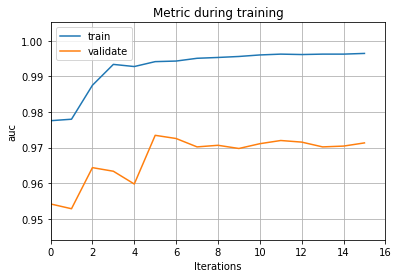

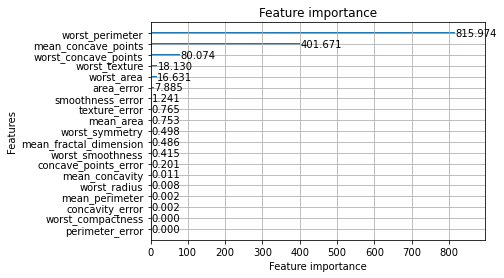

In [1]:
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

#================================================================================
# 一，读取数据
#================================================================================
printlog("step1: reading data...")

# 读取dftrain,dftest
breast = datasets.load_breast_cancer()
df = pd.DataFrame(breast.data,columns = [x.replace(' ','_') for x in breast.feature_names])
df['label'] = breast.target
df['mean_radius'] = df['mean_radius'].apply(lambda x:int(x))
df['mean_texture'] = df['mean_texture'].apply(lambda x:int(x))
dftrain,dftest = train_test_split(df)

categorical_features = ['mean_radius','mean_texture']
lgb_train = lgb.Dataset(dftrain.drop(['label'],axis = 1),label=dftrain['label'],
                        categorical_feature = categorical_features)

lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                        categorical_feature = categorical_features,
                        reference=lgb_train)

#================================================================================
# 二，设置参数
#================================================================================
printlog("step2: setting parameters...")
                               
boost_round = 50                   
early_stop_rounds = 10

params = {
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': ['auc'],
    'num_leaves': 31,   
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

#================================================================================
# 三，训练模型
#================================================================================
printlog("step3: training model...")


results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results)

#================================================================================
# 四，评估模型
#================================================================================
printlog("step4: evaluating model ...")

y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'],y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'],y_pred_test>0.5)))

lgb.plot_metric(results)
lgb.plot_importance(gbm,importance_type = "gain")

#================================================================================
# 五，保存模型
#================================================================================
printlog("step5: saving model ...")


model_dir = "../models/gbm.model"
print("model_dir: %s"%model_dir)
gbm.save_model("../models/gbm.model")
printlog("task end...")